In [11]:
import os

# Show the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# List all files in that directory
files = os.listdir(cwd)
print("Files here:", files)
import os
print("Working dir:", os.getcwd())
print("Files:", os.listdir())


Current working directory: c:\Users\Trader\Documents\spec-edge\lennar_hedge
Files here: ['.venv', 'app.py', 'hedge_dashboard.ipynb', 'hedge_model.py', 'hedge_model_notebook.ipynb', 'mock_pipeline.csv', 'mock_pipeline_realistic.csv', '__pycache__']
Working dir: c:\Users\Trader\Documents\spec-edge\lennar_hedge
Files: ['.venv', 'app.py', 'hedge_dashboard.ipynb', 'hedge_model.py', 'hedge_model_notebook.ipynb', 'mock_pipeline.csv', 'mock_pipeline_realistic.csv', '__pycache__']


In [12]:
import pandas as pd

# Load the realistic pipeline CSV
df = pd.read_csv("mock_pipeline_realistic.csv")

# Rename columns to match simulate_hedge_pnl's schema
df = df.rename(columns={
    "notional": "notional_usd",
    "duration": "duration_years",
    "pull_through": "pull_through_rate"
})

# Overwrite the file in place so downstream cells see the correct headers
df.to_csv("mock_pipeline_realistic.csv", index=False)

# Verify
print("Columns now:", df.columns.tolist())


Columns now: ['lock_date', 'notional_usd', 'duration_years', 'pull_through_rate']


In [13]:
# %% [markdown]
## Enable Auto-Reload for Local Modules

# %%
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FloatSlider(value=0.9, description='Coverage', max=1.0, min=0.5, step=0.05)

FloatSlider(value=0.005, description='Rate Vol', max=0.01, min=0.001, step=0.001)

IntSlider(value=10000, description='Sim Count', max=50000, min=1000, step=1000)

,Metric,Value
0,Hedge Coverage,90.0%
1,Total Notional ($M),6553.091247
2,Avg. Duration (yrs),6.031781
3,Mean P&L ($M),0.054558
4,STD P&L ($M),19.852073
5,5th %ile P&L ($M),-32.483389
6,95th %ile P&L ($M),32.741033


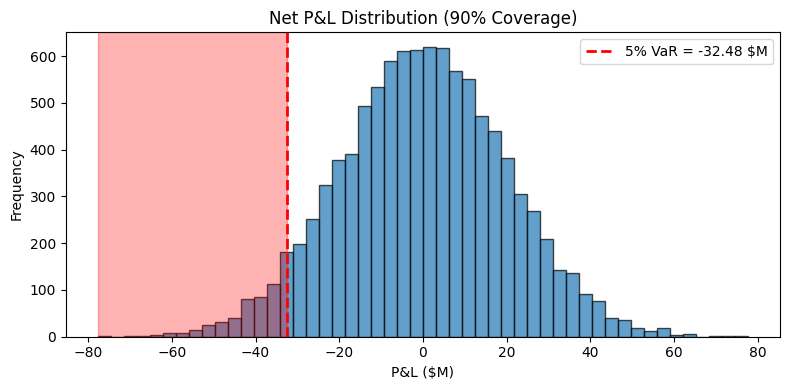

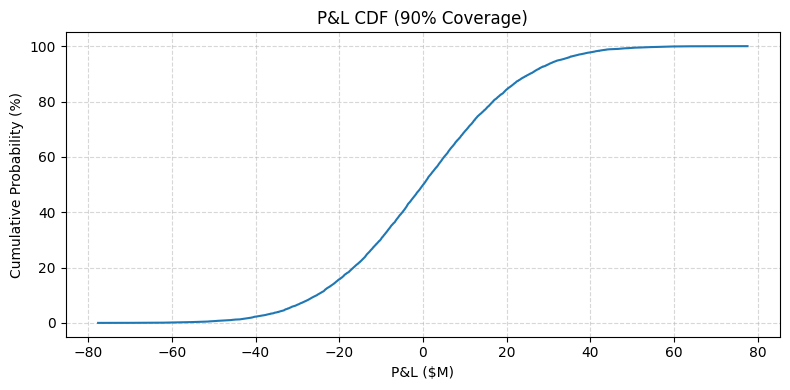

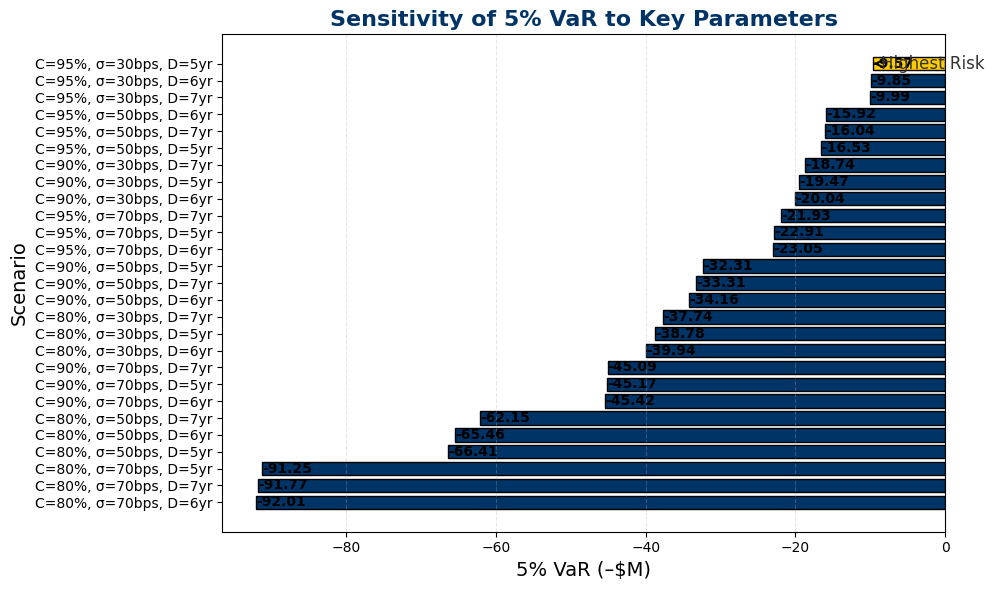

In [14]:
# %% [markdown]
## Parameter Definitions

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hedge_model import simulate_hedge_pnl
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define sliders
cov_slider = widgets.FloatSlider(min=0.5, max=1.0, step=0.05, value=0.9,
                                 description='Coverage')
vol_slider = widgets.FloatSlider(min=0.001, max=0.01, step=0.001, value=0.005,
                                 description='Rate Vol')
sim_slider = widgets.IntSlider(min=1000, max=50000, step=1000, value=10000,
                               description='Sim Count')

# Display sliders
display(cov_slider, vol_slider, sim_slider)

# %% [markdown]
## Monte Carlo Simulation

# %%
def summary_df(summary):
    """Convert summary dict to a displayable DataFrame."""
    df = pd.DataFrame({
        'Metric': [
            'Hedge Coverage', 'Total Notional ($M)', 'Avg. Duration (yrs)',
            'Mean P&L ($M)', 'STD P&L ($M)', '5th %ile P&L ($M)', '95th %ile P&L ($M)'
        ],
        'Value': [
            f"{summary['coverage']*100:.1f}%",
            summary['total_notional']/1e6,
            summary['avg_duration'],
            summary['mean_pnl']/1e6,
            summary['std_pnl']/1e6,
            summary['p5_pnl']/1e6,
            summary['p95_pnl']/1e6
        ]
    })
    return df

def run_simulation(coverage, rate_vol, sim_count):
    """Run the hedge simulation, display summary, and store results."""
    summary, results = simulate_hedge_pnl(
        'mock_pipeline_realistic.csv',
        coverage=coverage,
        rate_vol=rate_vol,
        n_sims=sim_count
    )
    display(summary_df(summary))
    globals()['latest_results'] = results

def on_value_change(change):
    clear_output(wait=True)
    display(cov_slider, vol_slider, sim_slider)
    run_simulation(cov_slider.value, vol_slider.value, sim_slider.value)

# Link widget changes to the simulation function
cov_slider.observe(on_value_change, names='value')
vol_slider.observe(on_value_change, names='value')
sim_slider.observe(on_value_change, names='value')

# Initialize simulation once
run_simulation(cov_slider.value, vol_slider.value, sim_slider.value)

# %% [markdown]
## Results & Visualization

# %%
def plot_var_histogram(pnl_series, coverage_label):
    data = pnl_series / 1e6
    cutoff = np.percentile(data, 5)

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.axvspan(data.min(), cutoff, color='red', alpha=0.3)
    ax.axvline(cutoff, color='red', linestyle='--', linewidth=2,
               label=f'5% VaR = {cutoff:.2f} $M')
    ax.set_title(f'Net P&L Distribution ({coverage_label})')
    ax.set_xlabel('P&L ($M)')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_cdf(pnl_series, coverage_label):
    data = np.sort(pnl_series / 1e6)
    p = np.linspace(0, 100, len(data))

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(data, p)
    ax.set_title(f'P&L CDF ({coverage_label})')
    ax.set_xlabel('P&L ($M)')
    ax.set_ylabel('Cumulative Probability (%)')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Grab the latest simulation results
pnl_series = latest_results['pnl']
coverage_label = f"{int(cov_slider.value*100)}% Coverage"

# Render charts
plot_var_histogram(pnl_series, coverage_label)
plot_cdf(pnl_series, coverage_label)
# %% [markdown]
## Enhanced Tornado Chart Styling

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hedge_model import simulate_hedge_pnl

# Rebuild the tornado DataFrame
param_grid = {
    'coverage': [0.80, 0.90, 0.95],
    'rate_vol': [0.003, 0.005, 0.007],
    'duration': [5, 6, 7]
}
tornado_data = []
for cov in param_grid['coverage']:
    for vol in param_grid['rate_vol']:
        for dur in param_grid['duration']:
            summary, _ = simulate_hedge_pnl(
                'mock_pipeline_realistic.csv',
                coverage=cov,
                rate_vol=vol,
                n_sims=5000
            )
            var5_m = summary['p5_pnl'] / 1e6
            label = f"C={int(cov*100)}%, σ={int(vol*10000):.0f}bps, D={dur}yr"
            tornado_data.append({'Scenario': label, 'VaR5 ($M)': var5_m})
df_tornado = pd.DataFrame(tornado_data).sort_values('VaR5 ($M)', ascending=True)

# Styling
n = len(df_tornado)
colors = ['#003366']*(n-1) + ['#FFCC00']  # Navy for all, gold for worst-case

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(df_tornado['Scenario'], df_tornado['VaR5 ($M)'], color=colors, edgecolor='black')

# Annotate each bar
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
            f"{width:.2f}", va='center', ha='left', fontweight='bold')

# Call out the worst-case
worst_idx = n - 1
worst_var = df_tornado['VaR5 ($M)'].iloc[worst_idx]
ax.annotate('Highest Risk',
            xy=(worst_var, worst_idx),
            xytext=(worst_var + 1, worst_idx),
            va='center',
            ha='left',
            fontsize=12,
            color='#333333',
            arrowprops=dict(facecolor='#333333', arrowstyle='->', lw=1.5))

# Titles, labels, and styling
ax.set_title('Sensitivity of 5% VaR to Key Parameters', fontsize=16, fontweight='bold', color='#003366')
ax.set_xlabel('5% VaR (–$M)', fontsize=14)
ax.set_ylabel('Scenario', fontsize=14)
ax.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()



In [15]:
import pandas as pd

# Load realistic pipeline
df = pd.read_csv("mock_pipeline_realistic.csv")

# Rename columns to what simulate_hedge_pnl expects
df = df.rename(columns={
    "notional": "notional_usd",
    "duration": "duration_years",
    "pull_through": "pull_through_rate"
})

# Overwrite the file in place
df.to_csv("mock_pipeline_realistic.csv", index=False)

print("✅ Columns now:", df.columns.tolist())


✅ Columns now: ['lock_date', 'notional_usd', 'duration_years', 'pull_through_rate']


In [16]:
import pandas as pd
import numpy as np

# 1) Q1 2025 estimate
#    Midpoint of 17k–17.5k homes × $430k avg price ≈ $7.42B total
homes_q1 = (17000 + 17500) / 2
avg_price = 430_000
total_volume = homes_q1 * avg_price  # ≈ $7.4175e9

# 2) Business days in Q1 2025
bdays = pd.bdate_range("2025-01-01", "2025-03-31")
n_days = len(bdays)  # 64

base_daily = total_volume / n_days  # ≈ 115.9M

# 3) Simulate realistic pipeline data
np.random.seed(42)
noise = np.random.normal(1.0, 0.10, n_days)   # ±10% noise
notional = base_daily * noise

durations = np.clip(
    np.random.normal(6.0, 0.5, n_days), 5.0, 7.0
)

pull_through = np.clip(
    np.random.normal(0.90, 0.02, n_days), 0.85, 0.95
)

df = pd.DataFrame({
    "lock_date": bdays,
    "notional": notional,
    "duration": durations,
    "pull_through": pull_through
})

# 4) Save to CSV
df["lock_date"] = df["lock_date"].dt.strftime("%Y-%m-%d")
df.to_csv("mock_pipeline_realistic.csv", index=False)

print("Wrote mock_pipeline_realistic.csv with", len(df), "rows")


Wrote mock_pipeline_realistic.csv with 64 rows


In [17]:
import pandas as pd
import numpy as np

n_loans = 500
np.random.seed(42)

notional = np.random.uniform(200000, 700000, size=n_loans)
duration = np.random.uniform(0.10, 0.20, size=n_loans)
pull_through = np.random.uniform(0.90, 0.98, size=n_loans)

date_rng = pd.date_range("2023-10-01", "2024-05-30", periods=n_loans)
np.random.shuffle(date_rng.values)
orig_date = date_rng.strftime('%Y-%m-%d')

coupon = np.clip(np.random.normal(6.75, 0.4, n_loans), 6.0, 8.0).round(2)

df = pd.DataFrame({
    "notional": notional.round(2),
    "duration": duration.round(3),
    "pull_through": pull_through.round(3),
    "orig_date": orig_date,
    "coupon": coupon,
    "strategy_type": "builder_forward"
})

df.to_csv("builder_forward_backtest.csv", index=False)
print("Generated 'builder_forward_backtest.csv' in your working directory!")


Generated 'builder_forward_backtest.csv' in your working directory!
